In [59]:
import pytesseract
import cv2
import base64
import time
from img_doc.editors.binarizer import ValleyEmphasisBinarizer
from img_doc.extractors.word_extractors import BaseWordExtractor
from img_doc.extractors.word_extractors.word_bold_extractor import PsBoldExtractor, WidthBoldExtractor, ISPBoldExtractor
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
from img_doc.extractors.block_extractors.block_label_extractor import *
from img_doc.data_structures import Word, Block
from img_doc.data_structures import Image, ImageSegment
import numpy as np
from typing import List
from io import StringIO
import json
import os

class TesseractWordExtractor(BaseWordExtractor):
    def extract_from_img(self, img: np) -> List[Word]:
        tesseract_bboxes = pytesseract.image_to_data(
            config="-l eng",
            image=img,
            output_type=pytesseract.Output.DICT)
        word_list = []
        for index_bbox, level in enumerate(tesseract_bboxes["level"]):
            if level == 5:
                word = Word(text = tesseract_bboxes["text"][index_bbox])
                word.set_point_and_size({
                    "x_top_left": tesseract_bboxes["left"][index_bbox],
                    "y_top_left": tesseract_bboxes["top"][index_bbox],
                    "width": tesseract_bboxes["width"][index_bbox],
                    "height": tesseract_bboxes["height"][index_bbox],
                })
                word_list.append(word)
        return word_list


class ImgDocManager:
    def __init__(self):
        self.word_ext = TesseractWordExtractor()
        self.kmeanext = KMeanBlockExtractor()
        self.LABEL_BLOCK_EXTRACTOR = {
            "mlp_len": MLPExtractor("../models/model-1.sav", {"len_vec": 5}),
            "mlp_len_ang": MLPAngLenExtractor("../models/model-1.sav", {"len_vec": 5}),
            "rnd_walk_dist": MLPRandomWalkExtractor("../models/model-1.sav", {"len_vec": 50}),
            "rnd_walk_many_dist": MLPRandomWalkManyDistExtractor("../models/model-1.sav", {"len_vec": 50})
        }
        self.binarizer = ValleyEmphasisBinarizer()
        


    def get_file_dataset(self, dataset, parametr, fun_get_image):
        list_vec = []
        list_y = []
        vec_len = parametr["vec_len"]
        model_type = parametr["model_type"]
        is_into_segment = lambda point, json_seg: (json_seg["x_top_left"] < point[0] and json_seg["x_bottom_right"] > point[0] and
                                                   json_seg["y_top_left"] < point[1] and json_seg["y_bottom_right"] > point[1])
        i = 0
        len_doc = len(dataset["documents"])
        for doc in dataset["documents"]:
            print(f"   {i/len_doc*100:.2f}%    ", end="\r")
            image = fun_get_image(doc["image64"])
            words = self.word_ext.extract_from_img(image.img)
            
            list_seg = [seg for seg in dataset["segments"] if seg["document_id"] == doc["id"]]
            for seg in list_seg:
                
                seg_words = [word for word in words if is_into_segment(word.segment.get_center(), json.loads(seg["json_data"]))]
                list_vec.append(self.LABEL_BLOCK_EXTRACTOR[model_type].get_vec_from_words(seg_words, vec_len).tolist())
                list_y.append(seg["marking_id"])
            
                    
            i+=1
        return {"x": list_vec, "y": list_y}

    def get_dataset_from_dir(self, path_dir, balans = 1000):
        train_images = os.path.join(path_dir, "train")
        with open(os.path.join(path_dir, "train.json"), "r") as f:
            train_json = json.load(f)
        dataset = dict()
        dataset["documents"] = [{"image64": img["file_name"], "id": img["id"]} for img in train_json["images"]]
        dataset["segments"] = []
        list_count_category = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
        
        for seg in train_json["annotations"]:
            
            if list_count_category[seg["category_id"]] < balans:
                dataset["segments"].append({"json_data": "{"+f'"x_top_left":{int(seg["bbox"][0])}, "y_top_left":{int(seg["bbox"][1])}, "x_bottom_right": {int(seg["bbox"][0]+seg["bbox"][2])}, "y_bottom_right": {int(seg["bbox"][1]+seg["bbox"][3])}'+"}",
                                "marking_id": seg["category_id"],
                                "document_id": seg["image_id"]
                               })
                list_count_category[seg["category_id"]] += 1
 
        return dataset
        

In [60]:
path_mini_publaynet = "/home/daniil/program/dataset/mini_publaynet"
path_mini_publaynet_train = "/home/daniil/program/dataset/mini_publaynet/train"

In [18]:
doc_manage = ImgDocManager()

In [19]:
dataset = doc_manage.get_dataset_from_dir(path_mini_publaynet)

In [20]:
def read_image(name_file):
    image = Image()
    image.set_img_from_path(os.path.join(path_mini_publaynet_train, name_file))
    return image

In [21]:
param = [1, 2, 3, 4, 5, 6]
# param[0] = {
#     "model_type": "mlp_len",
#     "vec_len": 5
# }

# param[1] = {
#     "model_type": "mlp_len",
#     "vec_len": 50
# }

# param[2] = {
#     "model_type": "mlp_len_ang",
#     "vec_len": 5
# }

# param[3] = {
#     "model_type": "mlp_len_ang",
#     "vec_len": 50
# }
# param[4] = {
#     "model_type": "rnd_walk_dist",
#     "vec_len": 50 
# }
param[5] = {
    "model_type": "rnd_walk_many_dist",
    "vec_len": 50 
}

In [22]:
print(len(dataset["segments"]))

5000


In [23]:
times_list = []
for p in param[5:]:
    start_time = time.time()
    with open(f"mini_publaynat_{p['model_type']}_veclen{p['vec_len']}.json", "w") as f:
        rez =doc_manage.get_file_dataset(dataset, p, read_image)
        json.dump(rez, f)
        times_list.append(time.time()-start_time)

print(times_list)

IndexError: list index out of range

In [27]:
import matplotlib.pyplot as plt

In [68]:
doc = dataset["documents"][5]
image = read_image(doc["image64"])

In [69]:
is_into_segment = lambda point, json_seg: (json_seg["x_top_left"] < point[0] and json_seg["x_bottom_right"] > point[0] and
                                                   json_seg["y_top_left"] < point[1] and json_seg["y_bottom_right"] > point[1])

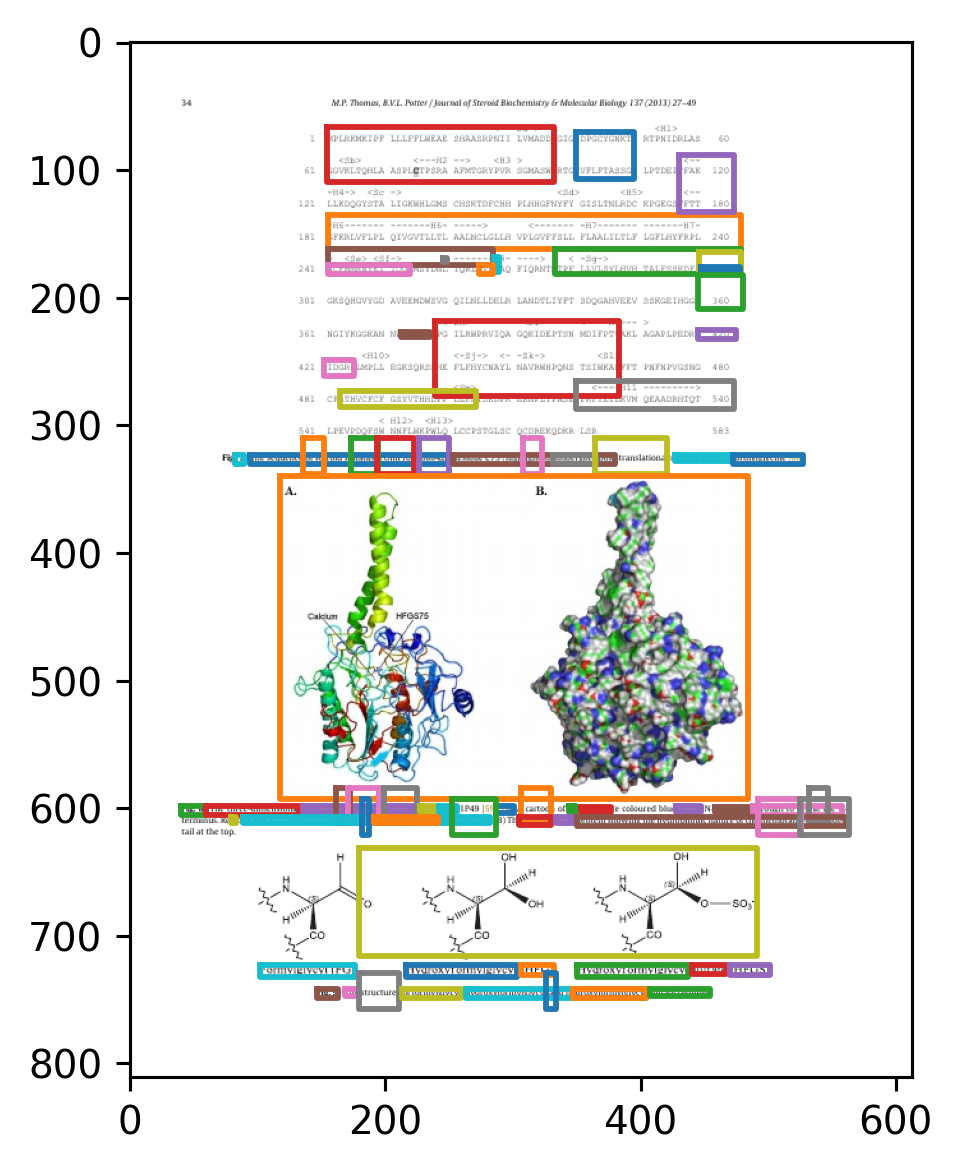

In [70]:
words = t.extract_from_img(image.img)
plt.figure(dpi=280)
plt.imshow(image.img)
for word in words:
  
    x0 = word.segment.x_top_left
    y0 = word.segment.y_top_left
    x1 = word.segment.x_bottom_right
    y1 = word.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])

In [71]:
a1 = time.time()

In [12]:
time.time()-a1

20.863629817962646

4 часа 22 мин (21, 18 мин соответственно)

In [61]:
t = TesseractWordExtractor()